# Custom mean functions: metalearning with GPs
One of the advantages of Gaussian process is their flexibility as a modeling tool. For instance, if the modeler knows that there is an underlying trend in the data, they can specify a mean function that captures this trend.

In this notebook, we illustrate how to use GPflow to construct a custom neural network mean function for GPs that can capture complex trends. We look at this functionality in the context of metalearning, where a number of metatasks are available at train time and the user wants to adapt a flexible model to new tasks at test time.

For an in-depth discussion on this topic, see *(Fortuin and Rätsch, 2019)*. This notebook reproduces section 4.2 of this paper.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import gpflow
from gpflow.kernels import RBF
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models import GPR
from gpflow.base import Parameter

from gpflow.ci_utils import ci_niter

%matplotlib inline

## Generate the tasks
To generate the meta and test tasks, we sample from a Gaussian process with an Squared Exponential covariance function and a sinusoidal mean function. Each task is a realization of this process.

In [2]:
def generate_data(num_functions=10, N=1000):
    jitter = 1e-6
    Xs = np.linspace(-5.0, 5.0, N)[:, None]
    kernel = RBF(lengthscale=1.)
    cov = kernel(Xs)
    L = np.linalg.cholesky(cov + np.eye(N) * jitter)
    epsilon = np.random.randn(N, num_functions)
    F = np.sin(Xs) + np.matmul(L, epsilon)
    return Xs, F

We generate 10 tasks for illustration.

In [3]:
Xs, F = generate_data(10)

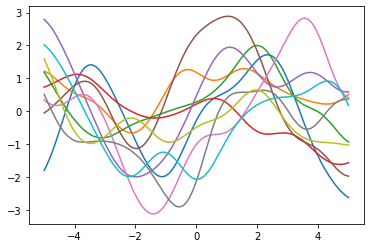

In [4]:
plt.plot(Xs, F);

We generate the meta and test tasks.

In [5]:
def generate_meta_and_test_tasks(num_datapoints, num_meta, num_test):
    N = 1000
    Xs, F = generate_data(num_functions=num_meta + num_test, N=N)
    meta_indices = [np.random.permutation(N)[:num_datapoints] for _ in range(num_meta)] 
    test_indices = [np.random.permutation(N)[:num_datapoints] for _ in range(num_test)]
    meta = []
    for i, mi in enumerate(meta_indices):
        Y = F[mi, i][:, None] + 1e-1 * np.random.randn(num_datapoints, 1)
        meta.append((Xs[mi], Y))
    test = []
    for i, ti in enumerate(test_indices):
        Y = F[ti, num_meta + i][:, None] + 1e-1 * np.random.randn(num_datapoints, 1)
        test.append(((Xs[ti], Y), (Xs, F[:, num_meta + i][:, None])))
    return meta, test

In [6]:
num_meta_tasks = 20
num_test_tasks = 5
num_datapoints = 5
meta, test = generate_meta_and_test_tasks(num_datapoints, num_meta_tasks, num_test_tasks)

## Create the mean function
We will use a Keras model Deep Neural Network as mean function.

In [7]:
from tensorflow.python.keras import backend as K
from gpflow.config import default_float

K.set_floatx('float64')
assert default_float() == np.float64

def build_mean_function():
    inputs = tf.keras.layers.Input(shape=(1,))
    x = tf.keras.layers.Dense(64, activation="relu")(inputs)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    outputs = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

## Build the GP metamodel
Metalearning boils down to learning a good prior that can generalize to new tasks with a small number of data points. This framework is prevalent in GP modeling, where we usually maximize the marginal likelihood to learn a good set of hyperparameters that specify the GP prior.

We perform the same optimization here, while sharing the hyperparameters across all the metatasks. For simplicity, we fix the kernel and likelihood parameters and learn those only for the mean function. Hence, our metalearning procedure is to cycle through the metatasks continuously, optimizing their marginal likelihood until a convergence criteria is reached (here, we just implement a fixed number of iterations over the tasks).

To begin this process, first we create a utility function that takes in a task (X, Y) and a mean function and outputs a GP model.

In [8]:
from gpflow.utilities import set_trainable

def build_model(data, mean_function):
    model = GPR(data, kernel=RBF(), mean_function=mean_function)
    set_trainable(model.kernel, False)
    model.likelihood.variance.assign(1e-2)
    set_trainable(model.likelihood, False)
    return model

In [9]:
def create_optimization_step(optimizer, model: gpflow.models.GPR):
    
    @tf.function(autograph=False)
    def optimization_step():
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(model.trainable_variables)
            objective = - model.log_marginal_likelihood()
            grads = tape.gradient(objective, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return objective
    return optimization_step

def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer
    
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    adam = tf.optimizers.Adam()
    optimization_step = create_optimization_step(adam, model)
    for step in range(iterations):
        elbo = optimization_step()
        if step % 10 == 0:
            # print("num variables", len(model.trainable_variables))
            logf.append(elbo.numpy())
    return logf

Next, we define the training loop for metalearning.

In [10]:
import time

def train_loop(meta_tasks, num_iter=5):
    """
    Metalearning training loop
    
    :param meta_tasks: list of metatasks.
    :param num_iter: number of iterations of tasks set
    :returns: a mean function object
    """
    # Initialize mean function
    mean_function = build_mean_function()
    # Iterate for several passes over the tasks set
    for iteration in range(num_iter):
        ts = time.time()
        print("Currently in meta-iteration {}".format(iteration))
        # Iterate over tasks
        for i, task in enumerate(meta_tasks):
            data = task  # (X, Y)
            model = build_model(data, mean_function=mean_function)
            run_adam(model, ci_niter(100))

        print(">>>> iteration took {} ms".format(time.time() - ts))
    return mean_function

mean_function_optimal = train_loop(meta)

Currently in meta-iteration 0


>>>> iteration took 3.500582456588745 ms
Currently in meta-iteration 1


>>>> iteration took 3.438795328140259 ms
Currently in meta-iteration 2


>>>> iteration took 3.5245628356933594 ms
Currently in meta-iteration 3


>>>> iteration took 3.5813345909118652 ms
Currently in meta-iteration 4


>>>> iteration took 3.433506965637207 ms


Finally, we use the optimized mean function for all of the test tasks. **NOTE:** We do not do any further optimization for the hyperparameters in this step.

In [11]:
test_models = [build_model(data, mean_function_optimal) for (data, _) in test]

## Assess the model
We assess the performance of this procedure on the test tasks. For this, we use the mean squared error as a performance metric.

In [12]:
def mean_squared_error(y, y_pred):
    return np.mean((y - y_pred) ** 2)

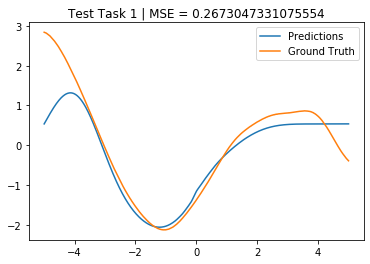

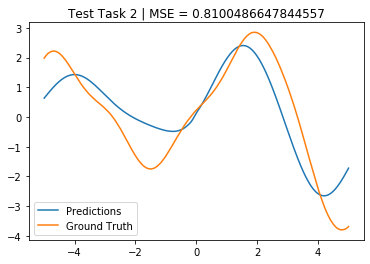

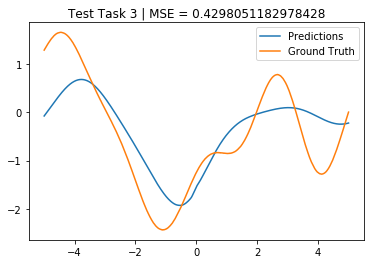

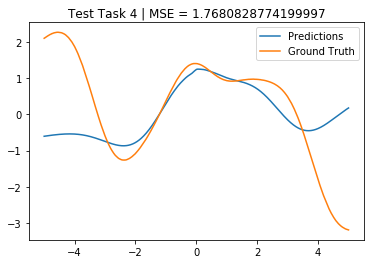

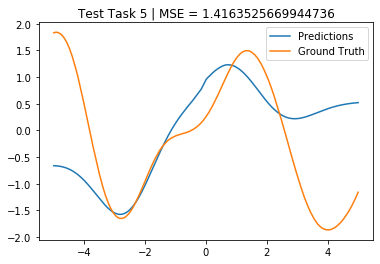

In [13]:
mean_squared_errors = []
for i, test_task in enumerate(test):
    (_, _), (Xs, F) = test_task
    pred = test_models[i].predict_f(Xs)
    plt.figure()
    plt.plot(Xs, pred[0], label='Predictions')
    plt.plot(Xs, F, label='Ground Truth')
    mse = mean_squared_error(F, pred[0])
    mean_squared_errors.append(mse)
    plt.title(f"Test Task {i + 1} | MSE = {mse}")
    plt.legend()

In [14]:
mean_mse = np.mean(mean_squared_errors)
std_mse = np.std(mean_squared_errors) / np.sqrt(num_test_tasks)
print(f"The mean MSE over all {num_test_tasks} test tasks is {mean_mse} +/- {std_mse}")

The mean MSE over all 5 test tasks is 0.9383187921208653 +/- 0.2563063773375625


We achieve comparable results to those reported in the paper.

**NOTE:** We use  only 20 metatasks and 5 test tasks for scalability, whereas the paper uses 1,000 and 200 respectively. Hence, there might be some discrepancies in the results.

## References
Fortuin, Vincent, and Gunnar Rätsch. "Deep Mean Functions for Meta-Learning in Gaussian Processes." arXiv preprint arXiv:1901.08098 (2019).